# Slings

Slings are modelled as a combination of cable and rigid-body nodes.
Cables are used for the eyes and the mid-section of the sling. Rigid-body nodes
are used to model the spliced section.
The mass of the sling is included in the rigidbody nodes.

The length of a sling is defined by the "ultimate" length. That is the length between the
insides of the eyes when the sling pulled tight over pins with a diameter of zero.

![image](./../images/sling_length.png)

Equilibrium-core version = 2.1
default resource folders:
c:\python\miniconda3\envs\book\lib\site-packages\DAVE\resources
C:\Users\beneden\DAVE_models
C:\data\Dave\Book\DAVE-book\DAVE-notebooks
Blender found at: C:\Program Files\Blender Foundation\Blender 2.93\blender.exe
embedWindow(verbose=True): could not load ipyvtk_simple try:
> pip install -U git+https://github.com/Kitware/ipyvtk-simple.git
Solved to 2.715e-04 kN


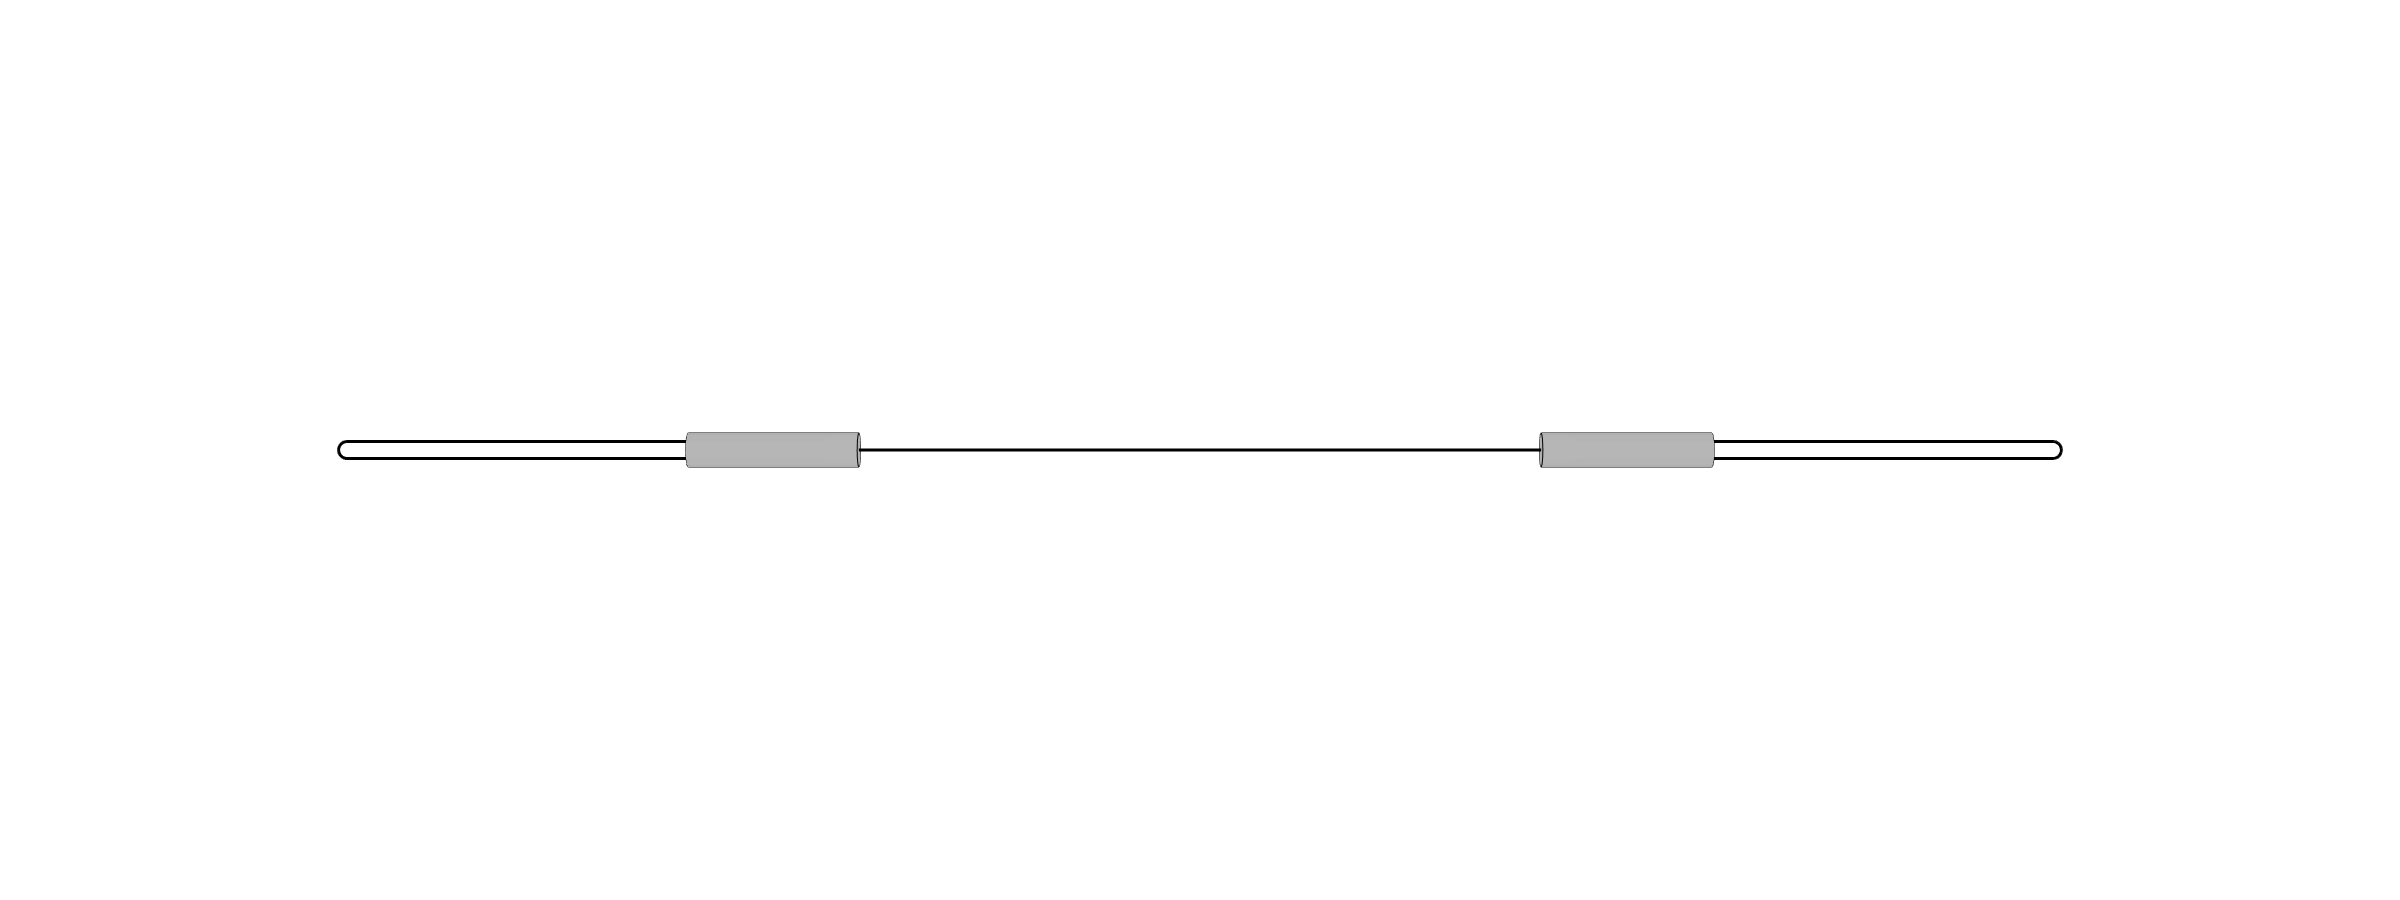

In [1]:
from DAVE import *
from DAVE.jupyter import *

s = Scene()

# code for Frame
s.new_frame(name='Frame',
           position=(5.0,
                     0.0,
                     0.0),
           rotation=(0.0,
                     0.0,
                     0.0),
           fixed =(False, True, True, True, True, True) )
# code for Point
s.new_point(name='Left',
          parent=None,
          position=(0.0,
                    0.0,
                    0.0))
# code for Point_1
s.new_point(name='Right',
          parent='Frame',
          position=(0.0,
                    0.0,
                    0.0))
# code for Circle
s.new_circle(name='Circle',
            parent='Left',
            axis=(0.0, 1.0, 0.0),
            radius=0.0 )
# code for Circle_1
s.new_circle(name='Circle_1',
            parent='Right',
            axis=(0.0, 1.0, 0.0),
            radius=0.0 )
# Exporting sling
# Create sling
sling = s.new_sling("sling", length = 10.0,
            LeyeA = 2,
            LeyeB = 2,
            LspliceA = 1,
            LspliceB = 1,
            diameter = 0.1,
            EA = 100000000.0,
            mass = 0.0,
            endA = "Circle",
            endB = "Circle_1",
            sheaves = None)

s.new_force('small_load', parent = 'Right', force = (1,0,0))

s.solve_statics()

show(s, camera_pos = (5, -10, 0),
     lookat = (5,0,0),
     painters = 'Visual',
     width=800,
     height=300,
     zoom_fit = False)

The distance between the insides of the loops is defined to be 10m.

This length is distributed over the following items:

| Item | Length [m] |
|------|--------|
|left eye | 2 |
|left splice | 1 |
|main part | 4 |
|right splice | 1 |
|right eye | 2 |

The amount of wire in the eyes is such that is accounts for the two legs as well as the length
of the bend around a zero diameter pin.

$L_{wire} = 2 * L_{eye} + \pi * d/2$

In this case the diamter of the wire is 0.1m which makes the length in the eye 2 * 2 + 3.141 * 0.1 * 0.5 = 4.157m


In [2]:
for n in s.nodes_of_type(Cable):
    report(n, ['length'])

Property,Value,Unit,Remarks,Explained
length,4.000,m,,Length of the cable when in rest


Property,Value,Unit,Remarks,Explained
length,4.157,m,,Length of the cable when in rest


Property,Value,Unit,Remarks,Explained
length,4.157,m,,Length of the cable when in rest


To double-check the length the sling is pulled tight by a small force. The distance between the
two zero-diameter pins should be just over 10m

- The left end of the sling is located at 0,0,0.
- the unstretched length of the sling is 10m
- The right pin should be at x=10m

In [3]:
print(f'Right at {s["Right"].global_position[0]:.3f}m')


Right at 10.000m


## Stiffness

The stiffness of the wire of the sling is defined by EA of the wire.
The wire (Cable) in the eyes of the sling has this EA.

![image](./../images/sling_EA.png)

In reality the splices of the sling should have a stiffness of 2 * EA. In the model however they
are modelled using a body with infinite stiffness.
The EA of the main-part is therefore adjusted to correct for that.


In practice it can be more practical to define the stiffness of the sling by its total stiffness (k).

$ k = { EA_{effective} \over L_{ultimate}}  [kN/m]$

$ k_{main} = EA / (L_{main}) $

$ k_{splice} = 2EA / (L_{splice}) $

$ k_{eye} = 4 EA / (L_{wire,eye}) $

$ k_{total} = { 1 \over 1/k_{eye,left} + 1/k_{splice,left} + 1/k_{main} + 1/k_{eye,right} + 1/k_{splice,right}} $




In [4]:
sling.EA = 1000 # kN/m
k = sling.k_total
print(sling.k_total)

141.2720738946259


Apply 141.27 kN of force, and check that the sling extends 1m.

- The left end of the sling is located at 0,0,0.
- the unstretched length of the sling is 10m
- The stretch is 1m

so the right end should be at x=11m

In [5]:
s['small_load'].force = (k,0,0)
s.solve_statics()

print(f'Right at {s["Right"].global_position[0]:.3f}m')


Solved to 5.403e-07 kN
Right at 11.000m


The total stiffness can also be set:

In [6]:
sling.k_total = 1000
print(f'Total stiffness set to {sling.k_total:.2f} [kN/m]')
print(f'Resulting EA: {sling.EA:.2f} [kN]')

Total stiffness set to 1000.00 [kN/m]
Resulting EA: 7078.54 [kN]


And check the extension for 1000 kN force:

In [7]:
s['small_load'].force = (1000,0,0)
s.solve_statics()

print(f'Right at {s["Right"].global_position[0]:.3f}m')

Solved to 1.066e-06 kN
Right at 11.000m


When changing the length of a sling, the EA stays the same. This means the k changes:

In [8]:
sling.length = 20

print(f'Total stiffness: {sling.k_total:.2f} [kN/m]')
print(f'Resulting EA: {sling.EA:.2f} [kN]')


Total stiffness: 414.47 [kN/m]
Resulting EA: 7078.54 [kN]
